In [21]:
## For each building see the archetype in each simulation and compare it 
import os
import geopandas as gpd
import pandas as pd


# Now get the data for block wise comparison
# Get the relevant blocks at the innner mierendorff Insel
# Load Block level data 
block_data = gpd.read_file(r'data\auxillary\00_block_shape.shp')
outer_mierendorff = ["019609", "019017", "019808", "019901", "020902", "019708"]
block_data['blknr'] = block_data["blknr"].astype(str)
block_data = block_data[~block_data["blknr"].isin(outer_mierendorff)]

CEA_SIMULATIONS_RESULTS = r"C:\Users\felix\Nextcloud\Back Up\04_Diss\08_Modelle\CEA\20241028_Postprocessed"

for project in os.listdir(CEA_SIMULATIONS_RESULTS):
    if project == "Benchmark":
        # Load the cea_shape and block_data GeoDataFrames
        cea_shape_path = os.path.join(CEA_SIMULATIONS_RESULTS, project, "2020", 'inputs', 'building-geometry', 'zone.shp')
        cea_shape = gpd.read_file(cea_shape_path)

        # Ensure cea_shape and block_data have the same CRS
        cea_shape = cea_shape.to_crs(block_data.crs)

        # Perform spatial join between `cea_shape` and `block_data`
        buildings_with_block = gpd.sjoin(cea_shape, block_data, how="inner", predicate='intersects')

        # Load cea_typology data
        cea_typology_path = os.path.join(CEA_SIMULATIONS_RESULTS, project, "2020", 'inputs', 'building-properties', 'typology.shp')
        cea_typology = gpd.read_file(cea_typology_path)

        # Set a CRS if cea_typology does not have one
        if cea_typology.crs is None:
            cea_typology.set_crs(cea_shape.crs, inplace=True)

        # Ensure cea_typology matches cea_shape's CRS
        cea_typology = cea_typology.to_crs(cea_shape.crs)

        # Merge `cea_shape` and `cea_typology` on 'Name' column
        # cea_shape = cea_shape.merge(cea_typology, on='Name', how='left', validate='1:1')

        # Continue to the next iteration of the loop after processing 'Benchmark' project
        continue

<Element {http://www.opengis.net/citygml/1.0}CityModel at 0x220b239d1c0>
<Element {http://www.opengis.net/citygml/1.0}CityModel at 0x220b2440a40>
<Element {http://www.opengis.net/citygml/1.0}CityModel at 0x220b23fdfc0>
<Element {http://www.opengis.net/citygml/1.0}CityModel at 0x220a0e8cd40>


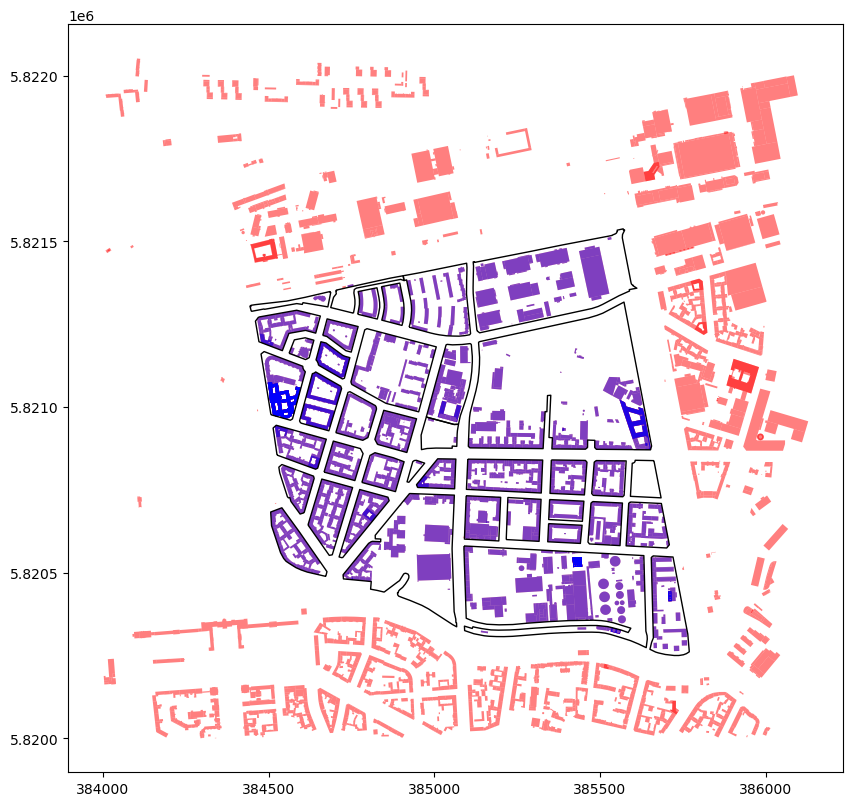

In [17]:
# Map GML ID to CEA ID 
import lxml.etree as ET
import shapely.geometry as geom
import matplotlib.pyplot as plt

ns = {
    'gml': 'http://www.opengis.net/gml',
    'bldg': 'http://www.opengis.net/citygml/building/2.0',
     'bldg' :"http://www.opengis.net/citygml/building/1.0"
}
# Code taken from https://github.com/TUB-DVG/TECDEM/blob/main/experiments/92a_ModelUpdatedGML.ipynb 

# ToDo - Write function to get building and building part IDs
gml_files = [os.path.join('data', 'examples', 'gml_data', file) for file in os.listdir(r'data\examples\gml_data') if file.endswith('.xml')]
# Extract building geometries along with their IDs

# Load shapefile
shapefile_path = os.path.join('data', 'auxillary','00_block_shape.shp')
blocks_gdf = gpd.read_file(shapefile_path)

# Get the relevant blocks at the innner mierendorff Insel
outer_mierendorff = ["019609", "019017", "019808", "019901", "020902", "019708"]
blocks_gdf['blknr'] = blocks_gdf["blknr"].astype(str)
blocks_gdf = blocks_gdf[~blocks_gdf["blknr"].isin(outer_mierendorff)]

def extract_ground_surface_polygons_with_ids(gml_root):
    buildings = []

    # Iterate over each building
    for bldg in gml_root.findall('.//{*}Building', ns):
        bldg_id = bldg.get('{http://www.opengis.net/gml}id')
        #print(bldg)

        # Find all GroundSurface elements within the boundedBy elements
        for ground_surface in bldg.findall('.//{*}GroundSurface', ns):
            pos_list_elements = ground_surface.findall('.//gml:posList', ns)
            if pos_list_elements is not None:
                for geom_elem in pos_list_elements:
                    pos_list = geom_elem.text.split()
                    if len(pos_list) % 3 != 0:
                        print(f"Warning: posList does not contain triplets of coordinates: {pos_list}")
                        continue
                    try:
                        # Convert coordinates to a 2D polygon (ignoring z-values)
                        exterior_coords = []
                        interior_coords = []
                        
                        # Find exterior coordinates
                        exterior = ground_surface.find('.//gml:exterior//gml:posList', ns)
                        if exterior is not None:
                            exterior_pos_list = exterior.text.split()
                            exterior_coords = [(float(exterior_pos_list[i]), float(exterior_pos_list[i + 1])) for i in range(0, len(exterior_pos_list), 3)]
                        
                        # Find interior coordinates
                        interiors = ground_surface.findall('.//gml:interior//gml:posList', ns)
                        for interior in interiors:
                            interior_pos_list = interior.text.split()
                            interior_coords.append([(float(interior_pos_list[i]), float(interior_pos_list[i + 1])) for i in range(0, len(interior_pos_list), 3)])
                        
                        # Create polygon with exterior and interior (holes)
                        polygon = geom.Polygon(exterior_coords, interior_coords)
                        buildings.append({'geometry': polygon, 'gml_id': bldg_id})
                    except Exception as e:
                        print(f"Error creating polygon for building {bldg_id}: {e}")
            else:
                # Alternatively, check for 'Polygon' elements under GroundSurface
                for poly in ground_surface.findall('.//gml:Polygon', ns):
                    exterior_coords = []
                    interior_coords = []
                    
                    # Find exterior coordinates
                    exterior = poly.find('.//gml:exterior//gml:posList', ns)
                    if exterior is not None:
                        exterior_pos_list = exterior.text.split()
                        if len(exterior_pos_list) % 3 != 0:
                            print(f"Warning: exterior posList does not contain triplets of coordinates: {exterior_pos_list}")
                            continue
                        exterior_coords = [(float(exterior_pos_list[i]), float(exterior_pos_list[i + 1])) for i in range(0, len(exterior_pos_list), 3)]
                    
                    # Find interior coordinates
                    interiors = poly.findall('.//gml:interior//gml:posList', ns)
                    for interior in interiors:
                        interior_pos_list = interior.text.split()
                        if len(interior_pos_list) % 3 != 0:
                            print(f"Warning: interior posList does not contain triplets of coordinates: {interior_pos_list}")
                            continue
                        interior_coords.append([(float(interior_pos_list[i]), float(interior_pos_list[i + 1])) for i in range(0, len(interior_pos_list), 3)])
                    
                    try:
                        # Create polygon with exterior and interior (holes)
                        polygon = geom.Polygon(exterior_coords, interior_coords)
                        buildings.append({'geometry': polygon, 'gml_id': bldg_id})
                    except Exception as e:
                        print(f"Error creating polygon for building {bldg_id}: {e}")

    return buildings



# Now, update the code to use the modified function
list_buildings = []
for gml_file in gml_files:
    tree = ET.parse(gml_file)
    root = tree.getroot()
    # Use the modified function that extracts only ground surfaces
    print(root)
    buildings = extract_ground_surface_polygons_with_ids(root)
    list_buildings.extend(buildings)  # Use extend to flatten the list

# Check if we have extracted any buildings
if not list_buildings:
    print("No buildings were extracted from the GML files.")
else:
    # Convert to GeoDataFrame
    buildings_gdf = gpd.GeoDataFrame(list_buildings, crs=blocks_gdf.crs)
    # Select columns using a list instead of a tuple
    columns_to_keep = ['blknr', 'plr', 'blktypname', 'ewk', 'area', 'geometry']
    blocks_gdf = blocks_gdf[columns_to_keep]
    # Check if buildings are within blocks
    buildings_gdf = buildings_gdf.reset_index(drop=True)
    blocks_gdf = blocks_gdf.reset_index(drop=True)
    within_blocks = gpd.sjoin(buildings_gdf, blocks_gdf, how='inner', predicate='intersects')


    # Optional: Plotting the results for visual inspection
    fig, ax = plt.subplots(figsize=(10, 10))
    blocks_gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
    buildings_gdf.plot(ax=ax, color='red', alpha=0.5)
    within_blocks.plot(ax=ax, color='blue', alpha=0.5)
    plt.show()

In [22]:
# spatial merge of within_blocks with data from cea

# Check and rename columns if necessary
if 'index_left' in within_blocks.columns:
    within_blocks = within_blocks.rename(columns={'index_left': 'index_left_'})
if 'index_right' in within_blocks.columns:
    within_blocks = within_blocks.rename(columns={'index_right': 'index_right_'})


# Now perform the spatial join
within_blocks = within_blocks.to_crs(cea_shape.crs)
merged_gdf = gpd.sjoin(within_blocks, cea_shape, how='inner', predicate='intersects')
merged_gdf.drop_duplicates()

,geometry,gml_id,index_right_,blknr,plr,blktypname,ewk,area,index_right,Name,...,descriptio,category,REFERENCE,house_no,street,postcode,house_name,resi_type,city,country
5,"POLYGON ((384976.272 5820790.551, 384977.076 5...",DEBE3D04YY50000BlO,24,020050,04300518,Block,100-999 Einwohner,7815.945312,101,B1115,...,NaN,apartments,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN
265,"POLYGON ((384988.955 5820786.719, 384983.965 5...",DEBE3D04YY50000PO8,24,020050,04300518,Block,100-999 Einwohner,7815.945312,101,B1115,...,NaN,apartments,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266,"POLYGON ((384976.272 5820790.551, 384970.271 5...",DEBE3D04YY50000PO8,24,020050,04300518,Block,100-999 Einwohner,7815.945312,101,B1115,...,NaN,apartments,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"POLYGON ((384976.272 5820790.551, 384977.076 5...",DEBE3D04YY50000BlO,24,020050,04300518,Block,100-999 Einwohner,7815.945312,102,B1116,...,NaN,apartments,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN
816,"POLYGON ((384982.867 5820756.296, 384983.381 5...",DEBE3D04YY500002HZ,24,020050,04300518,Block,100-999 Einwohner,7815.945312,102,B1116,...,NaN,apartments,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,"POLYGON ((385432.095 5820671.235, 385436.289 5...",DEBE3D04YY5000099k,30,020057,04300518,Block,100-999 Einwohner,6223.313965,663,B1779,...,NaN,residential,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2514,"POLYGON ((385451.196 5820716.044, 385450.221 5...",DEBE3D04YY5000099k,30,020057,04300518,Block,100-999 Einwohner,6223.313965,663,B1779,...,NaN,residential,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2515,"POLYGON ((385357.109 5820674.862, 385361.466 5...",DEBE3D04YY5000099k,30,020057,04300518,Block,100-999 Einwohner,6223.313965,663,B1779,...,NaN,residential,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2516,"POLYGON ((385446.861 5820661.111, 385435.534 5...",DEBE3D04YY5000099k,30,020057,04300518,Block,100-999 Einwohner,6223.313965,663,B1779,...,NaN,residential,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
merged_gdf = merged_gdf.drop_duplicates(subset=['gml_id', 'Name'])

In [38]:
archetypes_cea = merged_gdf.merge(cea_typology, on='Name')


In [100]:
# Gather Archetypes for SimStadt and 
# Combine the data for all years and calculate the average
RESULTS_FOLDER_SIMSTADT = r'C:\Users\felix\Nextcloud\Back Up\04_Diss\08_Modelle'
df_list = []

for year in [2020, 2021, 2022]:
    path = os.path.join(RESULTS_FOLDER_SIMSTADT, 'SimStadt', f'Mierendorff_{year}.proj', 'i.step', 'a.step', 'a.step', 'a.step', 'a.step', 'a.step', 'a.step')
    # get all results files in the folder
    print(path)
    files = []
    for file in os.listdir(path):
        if file.endswith('.csv'):
            files.append(os.path.join(path, file))

    skiprows = list(range(0, 19)) + [20]

    # read all files into a pandas dataframe
    df_18599 = pd.concat((pd.read_csv(file, skiprows=skiprows, sep=';', decimal=",") for file in files), ignore_index=True)
    df_18599['Year'] = year
    df_list.append(df_18599)

# Combine all years into a single dataframe
df_combined = pd.concat(df_list, ignore_index=True)

C:\Users\felix\Nextcloud\Back Up\04_Diss\08_Modelle\SimStadt\Mierendorff_2020.proj\i.step\a.step\a.step\a.step\a.step\a.step\a.step
C:\Users\felix\Nextcloud\Back Up\04_Diss\08_Modelle\SimStadt\Mierendorff_2021.proj\i.step\a.step\a.step\a.step\a.step\a.step\a.step
C:\Users\felix\Nextcloud\Back Up\04_Diss\08_Modelle\SimStadt\Mierendorff_2022.proj\i.step\a.step\a.step\a.step\a.step\a.step\a.step


In [101]:
df_combined = df_combined[['GMLId', 'ParentGMLId', 'Year of construction', 'Year of refurbishment',
                                      'Refurbishment Variant', 'ALKIS code', 'PrimaryUsageZoneType',
                                      'PrimaryUsageZoneArea', 'SecondaryUsageZoneType',
                                      'SecondaryUsageZoneArea', 'BuildingType', 'Footprint area', 'Gross volume',
                                      'Is Gross volume approximated?', 'Heated volume', 'Ridge/mean Height',
                                      'Storey number', 'Average Storey Height',
                                      'Number of households', 'Number of occupants',
                                      'Surface area to volume ratio', 'Heated area', 'Mean Uvalue',
                                      'Specific domestic hot water demand', 'Specific space heating demand',
                                      'Total Yearly Heat+DHW demand']]

In [64]:
df_combined = df_combined.rename(columns={'GMLId': 'gml_id'})

In [65]:

# Average, minimum and maximum 
# Code to get data for districtgenerator 
DG_RESULTS = r"C:\Users\felix\Nextcloud\Back Up\04_Diss\08_Modelle\Districtgenerator\20241025_MierendorffBaseline"
DG_MAPPING = r"C:\Users\felix\Nextcloud\Back Up\04_Diss\08_Modelle\Districtgenerator\20241018_Mierendorff_Baseline_updated_cleaned.csv"

import glob
dg_mapping = pd.read_csv(DG_MAPPING, sep=";")
dg_mapping



,id,building,year,retrofit,area,gml_id
0,0,AB,1900,0.0,6363.253906,DEBE3D04YY50000BlO
1,1,AB,1905,0.0,6519.537598,DEBE3D04YY50000Rac
2,2,IWU Transport,1905,0.0,23.834473,DEBE3D04YY50000DCT
3,3,AB,1905,0.0,1569.339844,DEBE3D04YY50000Lev
4,4,AB,1905,0.0,4516.176270,DEBE3D04YY500002JB
...,...,...,...,...,...,...
383,383,MFH,2005,0.0,5376.249756,DEBE3D04YY50000BfJ
384,384,AB,1905,0.0,6553.490234,DEBE3D04YY50000O01
385,385,MFH,2005,0.0,2809.338135,DEBE3D04YY50000F8S
386,386,AB,1905,0.0,8307.275391,DEBE3D04YY50000Qwb


In [66]:
archetypes = pd.merge(archetypes_cea, dg_mapping, on='gml_id', how='left')


In [67]:
archetypes = pd.merge(archetypes, df_combined, on='gml_id', how='left')


In [68]:
import re

NON_RESIDENTIAL_AGE_GROUPS = {
   "A": [1860, 1978],
    "B": [1979, 2009],
    "C": [2010, 2030],
}
RESIDENTIAL_AGE_GROUPS = {
    "A": [0, 1859],
    "B": [1860, 1918],
    "C": [1919, 1948],
    "D": [1949, 1957],
    "E": [1958, 1968],
    "F": [1969, 1978],
    "G": [1979, 1983],
    "H": [1984, 1994],
    "I": [1995, 2001],
    "J": [2002, 2009],
    "K": [2010, 2015],
    "L": [2016, 2030],
}

def get_age_group(standard):
    if re.match(r'^NWG', standard):
        age_groups = NON_RESIDENTIAL_AGE_GROUPS
        standard = standard.split("_")[-1]
    else:
        age_groups = RESIDENTIAL_AGE_GROUPS
        standard = standard.split("_")[1]
    
    return age_groups.get(standard, None)

def get_typology_age_group(standard):
    if re.match(r'^NWG', standard):
        age_groups = NON_RESIDENTIAL_AGE_GROUPS
        standard = standard.split("_")[-1]
    else:
        age_groups = RESIDENTIAL_AGE_GROUPS
        standard = standard.split("_")[1]
    
    return standard



standard_mapping = {
    "1": "IWU Office, Administrative or Government Buildings",
    "2": "IWU Research and University Teaching",
    "3": "IWU Health and Care",
    "4": "IWU School, Day Nursery and other Care", 
    "5":  "IWU Culture and Leisure",
    "6": "IWU Sports Facilities",
    "7": "IWU Hotels, Boarding, Restaurants or Catering", 
    "8": "IWU Production, Workshop, Warehouse or Operations",
    "9": "IWU Trade Buildings",
    "10": "IWU Technical and Utility (supply and disposal)",
    "11":  "IWU Transport",
    "G1": "IWU Generalized (1) Services building",
    "G2":"IWU Generalized (2) Production buildings"}

def map_standard(standard):
    if standard.startswith("AB") or standard.startswith("SFH") or standard.startswith("MFH") or standard.startswith("TH"):
        return standard.split('_')[0]
    elif standard.startswith("NWG"):
        parts = standard.split('_')[1]
        return standard_mapping.get(parts, "Unknown")
    return "Unknown"

archetypes['BuildingType CEA'] = archetypes['STANDARD'].apply(map_standard)
# Assuming df_cea is the DataFrame containing the column "STANDARD"
archetypes['Typology Age CEA'] = archetypes['STANDARD'].apply(get_typology_age_group)

def get_building_key_dg(building_type, year):
    if building_type in ["AB", "SFH", "SF", "TH", "MFH"]:
        for key, (start_year, end_year) in RESIDENTIAL_AGE_GROUPS.items():
            if start_year <= year <= end_year:
                return key
    elif building_type in ["IWU Hotels, Boarding, Restaurants or Catering", "IWU Office, Administrative or Government Buildings",
                           "IWU Trade Buildings", "IWU Technical and Utility (supply and disposal)", "IWU School, Day Nursery and other Care", "IWU Transport",
                           "IWU Health and Care", "IWU Sports Facilities", "IWU Culture and Leisure", "IWU Research and University Teaching", "IWU Technical and Utility (supply and disposal)",
                           "IWU Generalized (1) Services building", "IWU Generalized (2) Production buildings", "IWU Production, Workshop, Warehouse or Operations"]:
        for key, (start_year, end_year) in NON_RESIDENTIAL_AGE_GROUPS.items():
            if start_year <= year <= end_year:
                return key
    return None

# Assuming df_total_demand_per_alkis is the DataFrame containing the column "Year of construction"
archetypes['Typology Age Group DG'] = archetypes.apply(lambda row: get_building_key_dg(row['building'], row['year']), axis=1)

In [70]:
RESIDENTIAL_AGE_GROUPS = {
    "A": [0, 1859],
    "B": [1860, 1918],
    "C": [1919, 1948],
    "D": [1949, 1957],
    "E": [1958, 1968],
    "F": [1969, 1978],
    "G": [1979, 1983],
    "H": [1984, 1994],
    "I": [1995, 2001],
    "J": [2002, 2009],
    "K": [2010, 2015],
    "L": [2016, 2030],
}

def get_building_key_simstadt(year):
    for key, (start_year, end_year) in RESIDENTIAL_AGE_GROUPS.items():
        if start_year <= year <= end_year:
            return key
    return None

# Assuming df_total_demand_per_alkis is the DataFrame containing the column "Year of construction"
archetypes['Typology Age Group SimStadt'] = archetypes['Year of construction'].apply(get_building_key_simstadt)
rename_simstadt = {
    "EFH" : "SFH",
    "GMH" : "AB",
    "RH" : "TH",
    "HH" : "AB",
    "HR" : "AB",
    "MFH" : "MFH"
}

archetypes["BuildingType SimStadt"] = archetypes["BuildingType"].replace(rename_simstadt)

In [115]:
different_archetypes = archetypes[archetypes['BuildingType CEA'] != archetypes['building']][['building', 'BuildingType CEA', 'gml_id', 'Name', "ALKIS code", "category"]]



<Axes: >

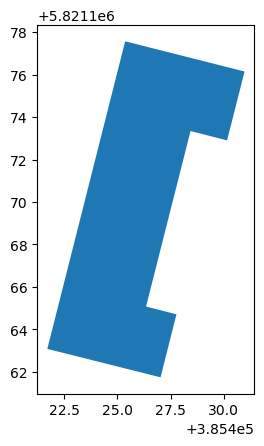

In [106]:
cea_shape[cea_shape['Name'].isin(["B1566", ])].plot()


In [85]:
archetypes[archetypes['Name'].isin(different_archetypes)][['building', 'year', 'BuildingType CEA', 'Typology Age CEA',
                                                          'Typology Age Group DG', 'Typology Age Group SimStadt',
                                                          'BuildingType SimStadt',  'Year of construction']]

,building,year,BuildingType CEA,Typology Age CEA,Typology Age Group DG,Typology Age Group SimStadt,BuildingType SimStadt,Year of construction
19,AB,1900.0,IWU Technical and Utility (supply and disposal),A,B,None,NaN,NaN
20,AB,1900.0,IWU Technical and Utility (supply and disposal),A,B,B,AB,1900.0
21,AB,1900.0,IWU Technical and Utility (supply and disposal),A,B,B,AB,1900.0
22,AB,1900.0,IWU Technical and Utility (supply and disposal),A,B,B,AB,1900.0
71,NaN,NaN,AB,B,None,B,SFH,1905.0
...,...,...,...,...,...,...,...,...
1524,AB,1905.0,AB,B,B,None,NaN,NaN
1525,"IWU Production, Workshop, Warehouse or Operations",1905.0,AB,B,A,None,NaN,NaN
1526,"IWU Production, Workshop, Warehouse or Operations",1905.0,AB,B,A,None,NaN,NaN
1527,IWU Transport,1905.0,AB,B,A,None,NaN,NaN


In [112]:
different_archetypes_GML = archetypes[(archetypes['BuildingType SimStadt'] != archetypes['building']) & archetypes['BuildingType SimStadt'].notna()][['building', 'year', 'BuildingType CEA', 'Typology Age CEA',
                                                          'Typology Age Group DG', 'Typology Age Group SimStadt',
                                                          'BuildingType SimStadt',  'Year of construction', "gml_id", "Name", "ALKIS code", "category"]]

In [113]:
different_archetypes_GML = different_archetypes_GML.drop_duplicates()

In [114]:
different_archetypes_GML

,building,year,BuildingType CEA,Typology Age CEA,Typology Age Group DG,Typology Age Group SimStadt,BuildingType SimStadt,Year of construction,gml_id,Name,ALKIS code,category
71,NaN,NaN,AB,B,None,B,SFH,1905.0,DEBE3D04YY500005Xu,B1161,2143.0,yes
279,SF,1905.0,AB,B,B,B,SFH,1905.0,DEBE3D04YY50000Lg8,B1213,1010.0,apartments
434,IWU Trade Buildings,1905.0,AB,B,A,B,TH,1905.0,DEBE3D04YY500005l3,B1074,2055.0,apartments
450,IWU Culture and Leisure,1905.0,IWU Culture and Leisure,A,A,B,MFH,1905.0,DEBE3D04YY5000006x,B1790,3041.0,church
461,IWU Culture and Leisure,1905.0,AB,B,A,B,MFH,1905.0,DEBE3D04YY5000006x,B1077,3041.0,apartments
...,...,...,...,...,...,...,...,...,...,...,...,...
1451,TH,1955.0,AB,D,D,D,AB,1955.0,DEBE3D04YY50000NIM,B1424,1010.0,residential
1456,TH,1955.0,AB,D,D,D,AB,1955.0,DEBE3D04YY50000NIM,B1426,1010.0,apartments
1462,TH,1955.0,AB,D,D,D,AB,1955.0,DEBE3D04YY50000NIM,B1427,1010.0,residential
1500,"IWU Production, Workshop, Warehouse or Operations",1905.0,AB,B,A,B,AB,1905.0,DEBE3D04YY50000FwN,B1094,2111.0,apartments


In [111]:
archetypes.columns


Index(['geometry_x', 'gml_id', 'index_right_', 'blknr', 'plr', 'blktypname',
       'ewk', 'area_x', 'index_right', 'Name', 'height_ag', 'floors_ag',
       'height_bg', 'floors_bg', 'descriptio', 'category', 'REFERENCE_x',
       'house_no', 'street', 'postcode', 'house_name', 'resi_type', 'city',
       'country', 'STANDARD', 'YEAR', '1ST_USE', '1ST_USE_R', '2ND_USE',
       '2ND_USE_R', '3RD_USE', '3RD_USE_R', 'REFERENCE_y', 'geometry_y', 'id',
       'building', 'year', 'retrofit', 'area_y', 'ParentGMLId',
       'Year of construction', 'Year of refurbishment',
       'Refurbishment Variant', 'ALKIS code', 'PrimaryUsageZoneType',
       'PrimaryUsageZoneArea', 'SecondaryUsageZoneType',
       'SecondaryUsageZoneArea', 'BuildingType', 'Footprint area',
       'Gross volume', 'Is Gross volume approximated?', 'Heated volume',
       'Ridge/mean Height', 'Storey number', 'Average Storey Height',
       'Number of households', 'Number of occupants',
       'Surface area to volume ratio'